# A/B Testing for New Payment Mechanics

## Introduction

EduPro is an online educational platform that offers a wide range of courses and micro-learning tasks for students worldwide. To increase monetisation efficiency, the platform’s product team launched an experiment testing a new payment mechanic for a selected group of users. This A/B test was designed to determine whether the new mechanic leads to an improvement in key financial and behavioural metrics.

## Goal

To determine whether the new payment mechanic should be launched for all users by analysing metrics.

## Objectives

The key objectives of this project are:

1. **Identify the key metrics** for evaluating the experiment.
2. **Compare metric** values between the control and pilot groups.
3. **Test** whether observed differences are statistically significant.
4. **Implement automated recalculation of metrics** using additional incoming user data.
5. **Visualize metric distributions** for easier interpretation.

## Data description

The dataset consists of four CSV files provided to analyse the results of the A/B test. Each file contains user-level information collected during the experiment window:
 - groups.csv – Contains user IDs and their assignment to either the control (A) or test (B) group at the time of the experiment launch.
 - groups_add.csv – Contains user IDs who were assigned to groups two days after the initial assignment (delayed inclusion).
 - active_studs.csv – Contains the IDs of users who were active (logged into the platform) during the experiment period.
 - checks.csv – Contains the IDs of users and the amount of money (rev) they paid during the experiment period.


## Libraries used

The following libraries are used throughout this project for data processing and visualization.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import normaltest
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import levene
from scipy.stats import ks_2samp

---

## Formulating the hypotheses

**Null Hypothesis (H₀)**:
The new payment mechanism has no statistically significant impact on user behaviour — there is no difference in key metrics (such as conversion to payment, average check, and revenue per user) between the control group (A) and the test group (B).

**Alternative Hypothesis (H₁)**:
The new payment mechanism has a statistically significant impact on user behaviour — there is a difference in key metrics (such as conversion to payment, average check, and revenue per user) between the control group (A) and the test group (B).

---

## Loading the necessary DataFrames for further analysis

In [2]:
def load_all_data(groups_path='data/groups.csv', 
                  groups_add_path='data/groups_add.csv', 
                  checks_path='data/checks.csv', 
                  active_studs_path='data/active_studs.csv'):
    try:
        groups = pd.read_csv(groups_path, sep=';')
        groups_add = pd.read_csv(groups_add_path)
        checks = pd.read_csv(checks_path, sep=';')
        active_studs = pd.read_csv(active_studs_path)
        
        groups.columns = ['student_id', 'group']
        groups_add.columns = ['student_id', 'group']
        checks.columns = ['student_id', 'revenue']
    except Exception as e:
        raise RuntimeError(f"Error loading data: {e}")
    
    return groups, groups_add, checks, active_studs

In [3]:
groups, groups_add, checks, active_studs = load_all_data()

---

## Merging the DataFrames into a single one

In [4]:
# Renaming the columns in the root DataFrame for consistency with other DFs and ease of use

groups.columns = ['student_id', 'group']
groups_add.columns = ['student_id', 'group']
checks.columns = ['student_id', 'revenue']

In [5]:
# Filtering to keep only active users

groups_active = groups[groups['student_id'].isin(active_studs['student_id'])]

In [6]:
# Checking: are there any paying but inactive ones?

paid_not_active = checks[~checks['student_id'].isin(active_studs['student_id'])]
print(f"Users who paid but are not active: {len(paid_not_active)}")

Users who paid but are not active: 149


In [7]:
# Joining on student_id

merged = groups_active.merge(checks, how='left', on='student_id')
merged.revenue = merged.revenue.fillna(0)

---

## Calculating the metrics

**Process description**

To evaluate the effectiveness of the new payment mechanic, I decided to focus on three key metrics: Conversion Rate (CR), Average Revenue Per User (ARPU), and Average Revenue Per Paying User (ARPPU).
 - **CR** helps assess how effectively users are converting from active status to paying customers.
 - **ARPU** gives an understanding of the overall revenue performance relative to the entire user base.
 - **ARPPU** isolates the analysis to only those who made a purchase, providing a clearer picture of spending behaviour.

These metrics together offer a balanced view of both engagement and monetisation, allowing for an informed comparison between the control and test groups.

In [8]:
# Grouping

grouped = merged.groupby('group').agg(
    users=('student_id', 'count'),
    payers=('revenue', lambda x: (x > 0).sum()),
    total_revenue=('revenue', 'sum')
)

In [9]:
# Calculating the metrics

grouped['cr'] = grouped['payers'] / grouped['users']
grouped['arpu'] = grouped['total_revenue'] / grouped['users']
grouped['arppu'] = grouped['total_revenue'] / grouped['payers']
grouped

,users,payers,total_revenue,cr,arpu,arppu
group,,,,,,
A,1535,78,72820.0000,0.050814,47.439739,933.589744
B,6793,313,393074.0035,0.046077,57.864567,1255.827487


---

## Normality сheck before statistical testing

**Process description**

Before deciding which statistical test to apply for ARPU and ARPPU, it is essential to check whether the data follows a normal distribution. This step comes after calculating the metrics but before running the A/B tests. The choice between using a parametric test (like the t-test) or a non-parametric alternative (like the Mann–Whitney U test) depends on the outcome of this normality check.

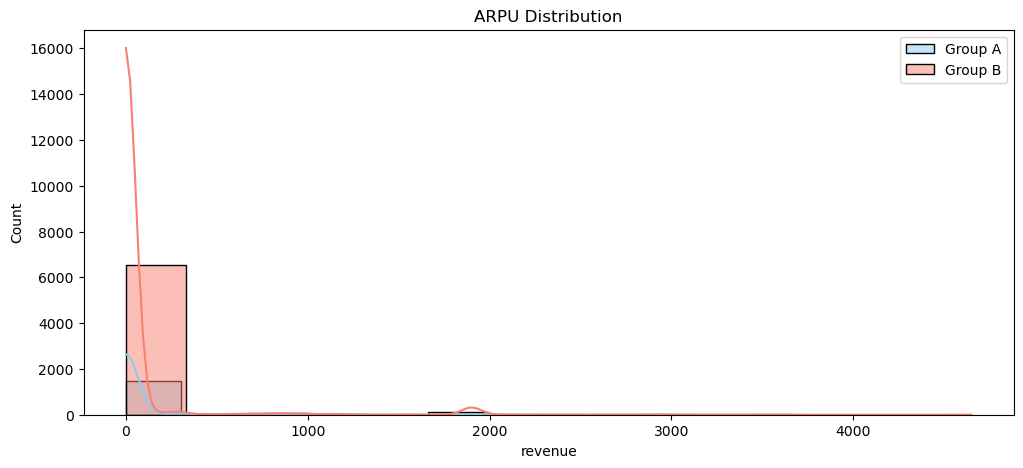

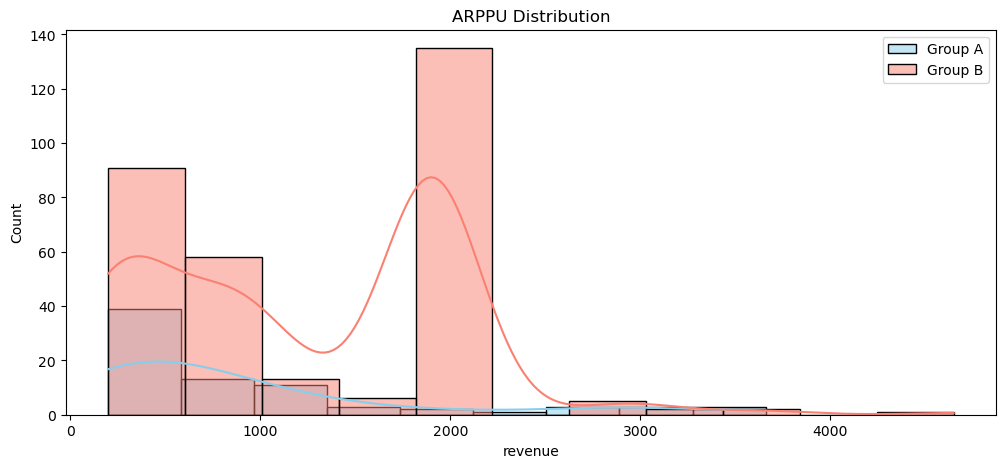

In [10]:
# ARPU
plt.figure(figsize=(12, 5))
sns.histplot(merged[merged['group'] == 'A']['revenue'], kde=True, label='Group A', color='skyblue')
sns.histplot(merged[merged['group'] == 'B']['revenue'], kde=True, label='Group B', color='salmon')
plt.title('ARPU Distribution')
plt.legend()
plt.show()

# ARPPU
plt.figure(figsize=(12, 5))
sns.histplot(merged[(merged['group'] == 'A') & (merged['revenue'] > 0)]['revenue'], kde=True, label='Group A', color='skyblue')
sns.histplot(merged[(merged['group'] == 'B') & (merged['revenue'] > 0)]['revenue'], kde=True, label='Group B', color='salmon')
plt.title('ARPPU Distribution')
plt.legend()
plt.show()

In [11]:
# ARPU
arpu_A = merged[merged['group'] == 'A']['revenue']
arpu_B = merged[merged['group'] == 'B']['revenue']

print("Normality test for ARPU:")
print("Group A:", normaltest(arpu_A))
print("Group B:", normaltest(arpu_B))

# ARPPU
arppu_A = merged[(merged['group'] == 'A') & (merged['revenue'] > 0)]['revenue']
arppu_B = merged[(merged['group'] == 'B') & (merged['revenue'] > 0)]['revenue']

print("\nNormality test for ARPPU:")
print("Group A:", normaltest(arppu_A))
print("Group B:", normaltest(arppu_B))

Normality test for ARPU:
Group A: NormaltestResult(statistic=2235.0038926868115, pvalue=0.0)
Group B: NormaltestResult(statistic=7799.5839920248845, pvalue=0.0)

Normality test for ARPPU:
Group A: NormaltestResult(statistic=30.378419638487475, pvalue=2.5316868804220266e-07)
Group B: NormaltestResult(statistic=7.022269699078301, pvalue=0.029863005181946005)


**Interpretation of the normality test**

**ARPU**:
 - Group A: p-value = 0.0
 - Group B: p-value = 0.0

**ARPPU**:
 - Group A: p-value ≈ 2.5e-07
 - Group B: p-value ≈ 0.029

**Conclusion**:

In all cases, p-value < 0.05, which means:
 - The distribution is not normal.
 - **t-test cannot be used**, even for Group B in ARPPU, where p-value ≈ 0.029 — it’s still below the threshold.

In [12]:
stat_var_arpu, p_var_arpu = levene(
    merged[merged['group'] == 'A']['revenue'],
    merged[merged['group'] == 'B']['revenue']
)
print(f"Levene’s test for ARPU variances: p = {p_var_arpu}")

Levene’s test for ARPU variances: p = 0.2328800964326769


**Note**:
For completeness, a variance check (Levene’s test) was also performed.
However, since the data is clearly not normally distributed (p-value ≈ 0), the result of the variance test does not affect the choice of method: t-tests are not applicable, and a non-parametric approach is used instead.

---

## A/B testing

**Process description**

To evaluate the statistical significance of the observed differences between the control and test groups, we selected specific hypothesis tests based on the type and distribution of the metrics:
 - **Z-test for Conversion Rate (CR)**: Since CR is a proportion metric (number of payers divided by total users), a Z-test is appropriate for comparing proportions between two independent groups, especially with large sample sizes.
 - **Mann–Whitney U test for ARPU and ARPPU**: Normality tests showed that both ARPU and ARPPU distributions deviate from normality (p-value < 0.05). Therefore, instead of a t-test (which assumes normal distribution), we used the non-parametric Mann–Whitney U test, which is more robust in such cases and compares the medians of two independent samples.

In [13]:
# Z-test for Conversion Rate (CR)

n1 = grouped.loc['A', 'users']
x1 = grouped.loc['A', 'payers']
n2 = grouped.loc['B', 'users']
x2 = grouped.loc['B', 'payers']

z_stat, p_value = proportions_ztest(count=[x1, x2], nobs=[n1, n2])

print(f'z-stat = {z_stat:.4f}, p-value = {p_value:.4f}')

z-stat = 0.7925, p-value = 0.4281


In [14]:
# KS-test for ARPU

arpu_A = merged[merged['group'] == 'A']['revenue']
arpu_B = merged[merged['group'] == 'B']['revenue']

stat_arpu, pval_arpu = ks_2samp(arpu_A, arpu_B)
print(f'KS-test for ARPU: statistic = {stat_arpu:.4f}, p-value = {pval_arpu:.4f}')

KS-test for ARPU: statistic = 0.0142, p-value = 0.9592


In [15]:
# KS-test for ARPPU

arppu_A = merged[(merged['group'] == 'A') & (merged['revenue'] > 0)]['revenue']
arppu_B = merged[(merged['group'] == 'B') & (merged['revenue'] > 0)]['revenue']

stat_arppu, pval_arppu = ks_2samp(arppu_A, arppu_B)
print(f'KS-test for ARPPU: statistic = {stat_arppu:.4f}, p-value = {pval_arppu:.4f}')

KS-test for ARPPU: statistic = 0.3222, p-value = 0.0000


**Interpretation of A/B test results**

**Conversion Rate (share of paying users)**
 - p-value = 0.4281 — no statistically significant difference
 - Conclusion: the new payment mechanic did not impact the share of paying users

**ARPU (Average Revenue Per User)**
 - p-value = 0.9592 — no statistically significant difference
 - Conclusion: the average revenue per user remained unchanged

**ARPPU (Average Revenue Per Paying User)**
 - p-value = 0.0000 — **statistically significant difference**
 - Conclusion: paying users in the test group started spending more

---

## Final conclusion: Should the new payment mechanic be scaled?

The new payment mechanic **did not lead to an increase** in:
 - the share of paying users,
 - the average revenue per user.

However, it **significantly increased the average revenue per paying user (ARPPU)**, which may be valuable if the goal is to maximise revenue from active paying users, this mechanic can be scaled — especially within segments with a high probability of purchase. Otherwise, it’s advisable to test it more selectively or combine it with other initiatives.

---

## Post-experiment update: Adding late user group & refreshing metrics

**Process description**

Two days after the experiment, an additional file (**groups_add.csv**) was received, containing a supplementary batch of users with assigned groups.

Although this data arrived after the main experiment analysis was completed, it’s important to recalculate key product metrics (CR, ARPU, ARPPU) using the extended dataset — not for statistical comparison, but for monitoring and operational insight.

In this section:
 - We merge the late-arriving user data (**groups_add.csv**) with the original group assignment file.
 - We recalculate all key metrics (CR, ARPU, ARPPU) using the extended user base.
 - We visualise the updated results via bar charts for a clearer understanding of current performance.
 - Importantly, we encapsulate the entire logic in a reusable function, designed to handle such future cases — when experiments evolve and new users arrive after the main analysis has been performed.

**Note**: This step does not involve A/B testing. No hypothesis testing is performed. The focus is purely on metric recalculation and visualisation using the extended dataset.

In [16]:
# Encapsulating the metric recalculation logic into a reusable function

def recalculate_metrics(groups, groups_add, active_studs, checks):
    # Concating the groups
    
    all_groups = pd.concat([groups, groups_add])
    
    # Merging with active students
    
    groups_active = all_groups[all_groups['student_id'].isin(active_studs['student_id'])]
    
    # Merging with checks
    
    merged = groups_active.merge(checks, how='left', on='student_id')
    merged.revenue = merged.revenue.fillna(0)

    # Grouping and calculating metrics
    
    grouped = merged.groupby('group').agg(
        users=('student_id', 'count'),
        payers=('revenue', lambda x: (x > 0).sum()),
        total_revenue=('revenue', 'sum')
    )
    grouped['cr'] = grouped['payers'] / grouped['users']
    grouped['arpu'] = grouped['total_revenue'] / grouped['users']
    grouped['arppu'] = grouped['total_revenue'] / grouped['payers']

    return grouped

In [17]:
recalculate_metrics(groups, groups_add, active_studs, checks)

,users,payers,total_revenue,cr,arpu,arppu
group,,,,,,
A,1538,78,72820.0000,0.050715,47.347204,933.589744
B,6803,314,394974.0035,0.046156,58.058798,1257.878992


In [18]:
# Graphs building

def plot_metrics(grouped):
    # Plot configuration
    
    sns.set(style="whitegrid")
    metrics = ['cr', 'arpu', 'arppu']
    titles = [
        'Conversion Rate (CR)',
        'ARPU (Average Revenue Per User)',
        'ARPPU (Average Revenue Per Paying User)'
    ]
    colors = ['lightgreen', 'skyblue', 'salmon']

    plt.figure(figsize=(18, 5))

    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i + 1)
        sns.barplot(x=grouped.index, y=grouped[metric].values, color=colors[i])
        plt.title(titles[i])
        plt.ylabel(metric.upper())
        plt.xlabel('Group')

    plt.tight_layout()
    plt.show()

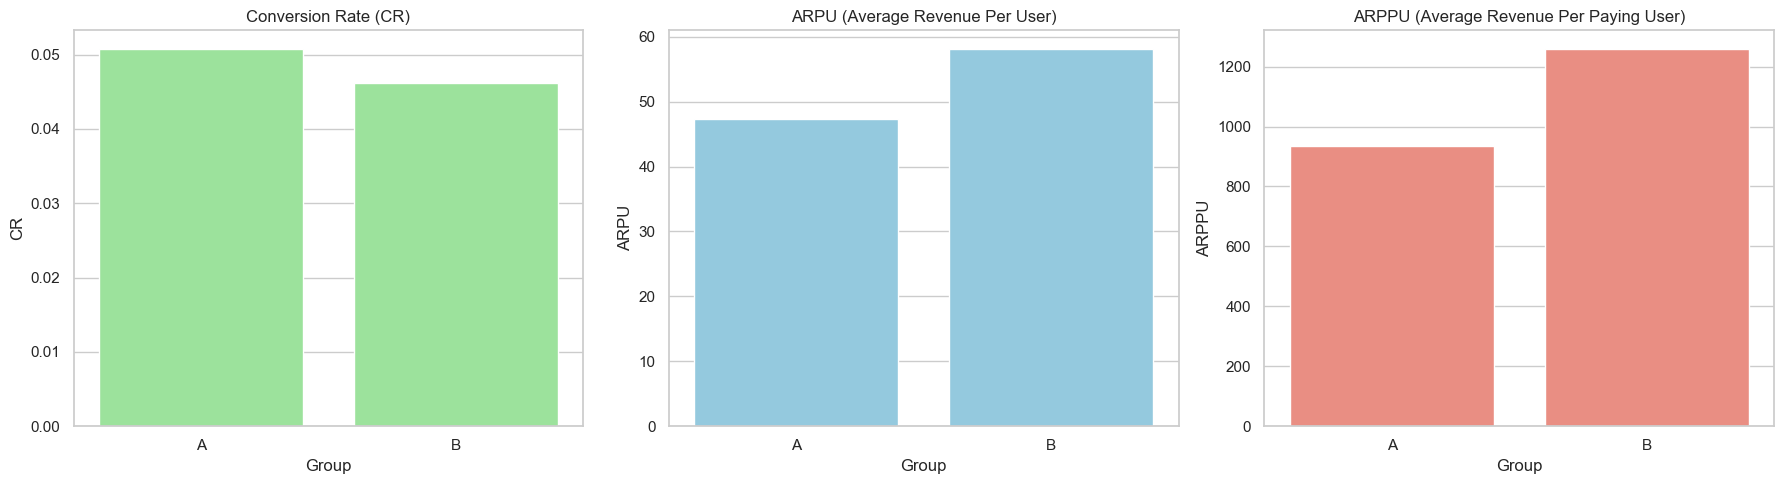

In [19]:
grouped = recalculate_metrics(groups, groups_add, active_studs, checks)
plot_metrics(grouped)

---

## Summary

In this project, we conducted a comprehensive A/B test to evaluate the impact of a new payment mechanism on user behaviour. We analysed the differences between control and test groups using core metrics such as Conversion Rate (CR), Average Revenue Per User (ARPU), and Average Revenue Per Paying User (ARPPU). Based on the statistical tests (Z-test and Mann–Whitney U), we concluded that the new mechanic did not significantly affect the number of paying users or average revenue per user. However, it did result in a significant increase in revenue from paying users, suggesting a potential for monetisation improvements within targeted segments.

In the final section, we simulated a scenario where additional user data became available post-experiment. To address this, we designed a reusable function that recalculates metrics by dynamically merging new inputs into the existing pipeline. This approach ensures scalability of the analysis framework and enables accurate tracking of performance when external data updates are introduced after the main evaluation phase.

The project demonstrates the importance of well-structured metric pipelines and hypothesis-driven experimentation when validating product improvements in a real-world data environment.